<a href="https://colab.research.google.com/github/IfThenElze/Sudoku_image_classification/blob/main/Sudoku_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

https://www.kaggle.com/datasets/rohit369/sudoku-digit-classification

# Code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import os
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import expand_dims

In [ ]:
path_sudoku_train = '/content/drive/MyDrive/UNP seminarski/Sudoku cifre/train_data'
path_sudoku_test = '/content/drive/MyDrive/UNP seminarski/Sudoku cifre/test_data'
path_sudoku_validation = '/content/drive/MyDrive/UNP seminarski/Sudoku cifre/validation_data'


In [ ]:
train_sudoku = tf.keras.preprocessing.image_dataset_from_directory(path_sudoku_train)
print(type(train_sudoku))
print(train_sudoku.class_names)

Found 4503 files belonging to 10 classes.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
N=list(range(len(train_sudoku.class_names)))
normal_mapping=dict(zip(train_sudoku.class_names,N))
reverse_mapping=dict(zip(N,train_sudoku.class_names))
print(normal_mapping)
print(reverse_mapping)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}


In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)

height = 64
width = 64
batch_size = 32
img_size = (height, width)

train_data_sudoku = datagen.flow_from_directory(
    path_sudoku_train,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = True)
test_data_sudoku = datagen.flow_from_directory(
    path_sudoku_test,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = False)
validation_data_sudoku = datagen.flow_from_directory(
    path_sudoku_validation,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = True)

Found 4503 images belonging to 10 classes.
Found 289 images belonging to 10 classes.
Found 108 images belonging to 10 classes.


In [ ]:
categories=list(train_data_sudoku.class_indices.keys())
print(categories)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Distribution of images among all classes of traning, test and validation set

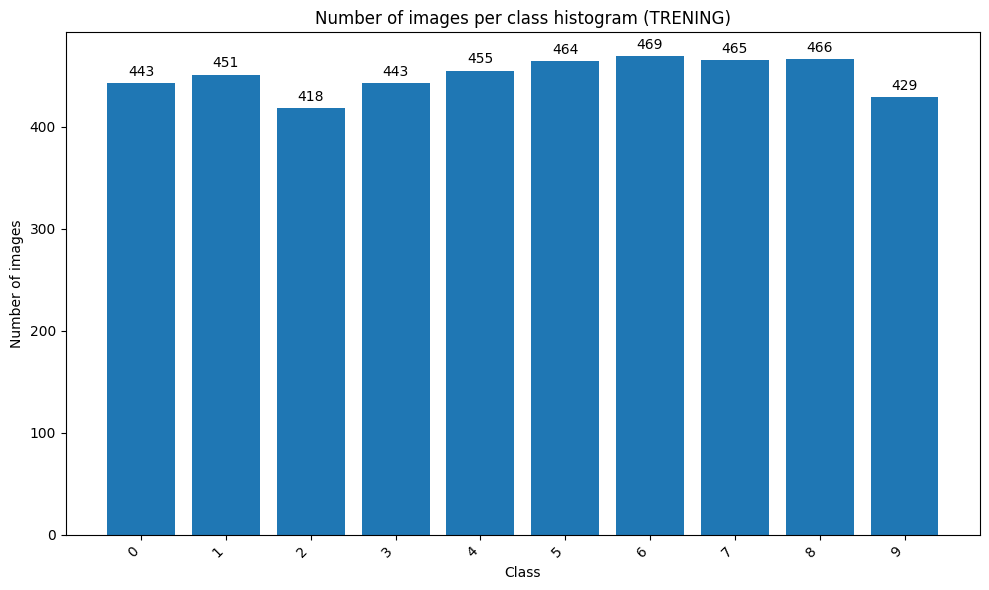

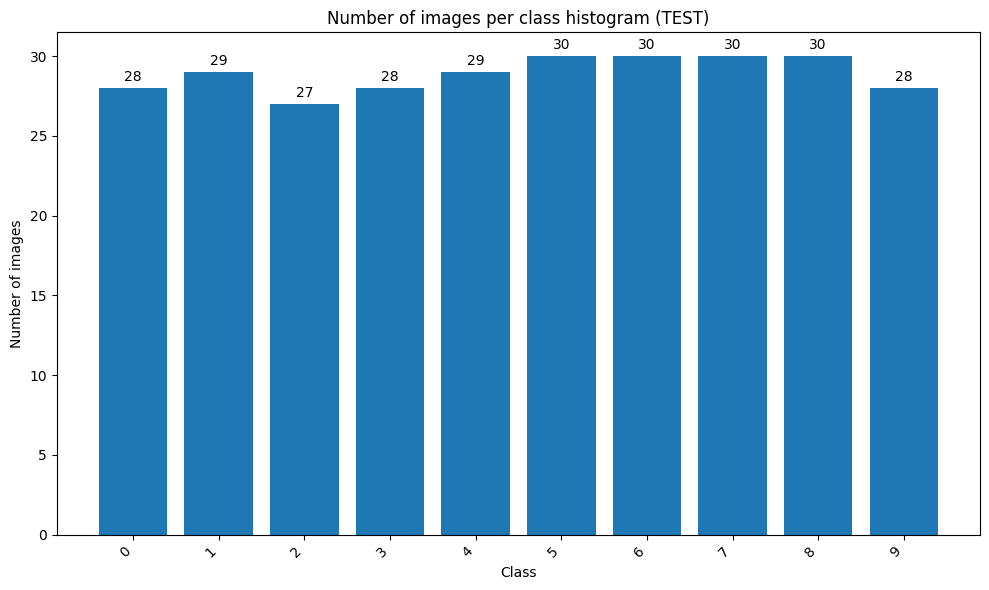

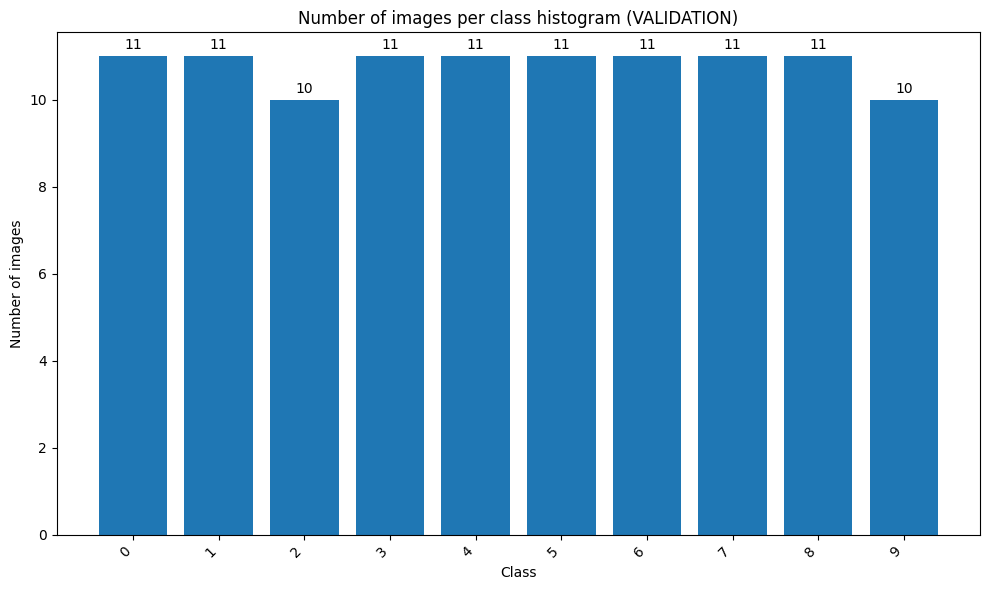

In [ ]:
def hist(data, skup):
  n_images=data.classes.tolist()
  histogram=[n_images.count(i) for i in range(len(categories))]
  fig, ax = plt.subplots(figsize=(10, 6))
  bars= plt.bar(categories,histogram)
  for bar in bars:
      height = bar.get_height()
      ax.annotate('{}'.format(height),
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 3),
                  textcoords="offset points",
                  ha='center', va='bottom')
  ax.set_xlabel('Class')
  ax.set_ylabel('Number of images')
  ax.set_title(f'Number of images per class histogram ({skup.upper()})')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

hist(train_data_sudoku, "trening")
print()
hist(test_data_sudoku, "test")
print()
hist(validation_data_sudoku, "validation")

## Sample overview

In [ ]:
def show_img(data):
  imgs, labels = next(iter(data))
  i=1
  plt.figure(figsize=(15,15))
  for img, label in zip(imgs, labels):
      ax=plt.subplot(8,4,i)
      value=np.argmax(label)
      labelname=reverse_mapping[value]
      plt.imshow(img, cmap='gray', vmin=0, vmax=1)
      plt.title(labelname)
      i=i+1
      plt.axis("off")

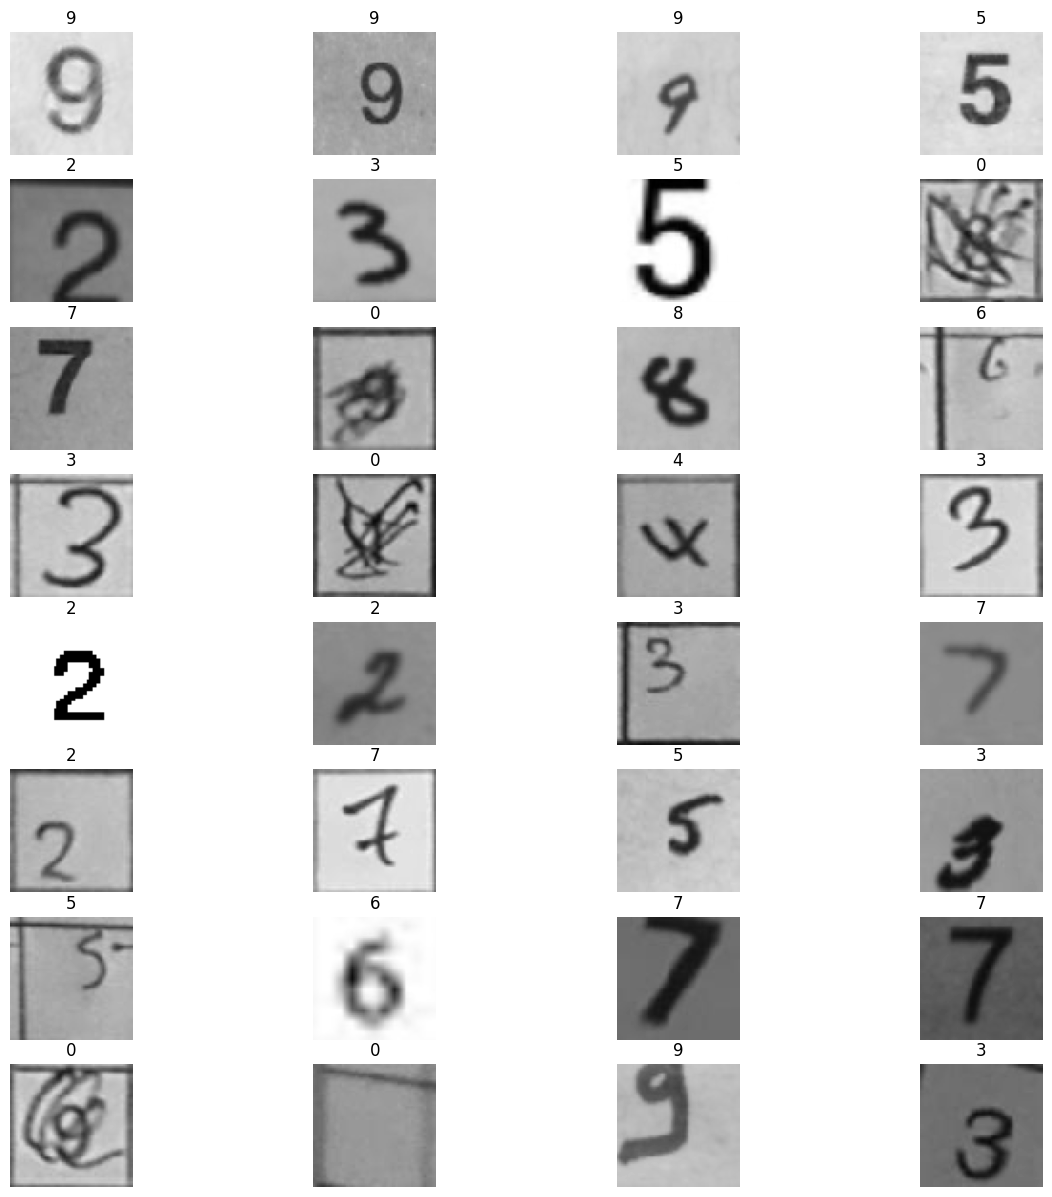

In [ ]:
show_img(train_data_sudoku)

## Model 3.3 (vgg16 + augmentation)

### Input with augmentation

In [ ]:
datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    zoom_range = 0.1,
    brightness_range=(0.5,1.5),
    fill_mode="nearest"
)

batch_size = 256;
img_size_64 = (64, 64)

train_data_sudoku_vgg = datagen_aug.flow_from_directory(
    path_sudoku_train,
    target_size = img_size_64,
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle = True)
test_data_sudoku_vgg = datagen_aug.flow_from_directory(
    path_sudoku_test,
    target_size = img_size_64,
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle = False)
validation_data_sudoku_vgg = datagen_aug.flow_from_directory(
    path_sudoku_validation,
    target_size = img_size_64,
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle = True)


Found 4503 images belonging to 10 classes.
Found 289 images belonging to 10 classes.
Found 108 images belonging to 10 classes.


### Model preparation

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
model3_3 = tf.keras.models.Sequential()
model3_3.add(conv_base)
model3_3.add(tf.keras.layers.Flatten())
model3_3.add(tf.keras.layers.Dense(10, activation='softmax'))
model3_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 14735178 (56.21 MB)
Trainable params: 14735178 (56.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Fine-tuning

In [ ]:
print('Number of trainable weights before freezing the conv base:', len(model3_3.trainable_weights))
for layer in conv_base.layers[:15]:
    layer.trainable = False

for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)
print('Number of trainable weights after freezing the conv base:', len(model3_3.trainable_weights))
model3_3.summary()

Number of trainable weights before freezing the conv base: 28
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Number of trainable weights after freezing the conv base: 8
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
  

### Model training

In [ ]:
model_path = '/content/drive/MyDrive/UNP seminarski/Modeli/model3_3.hdf5'
save_callback3_3 = ModelCheckpoint(
  filepath= model_path,
  save_best_only=True,
  monitor="val_loss",
  verbose=1,
)

In [ ]:
print('type "confirm" to continue')
if (input() == "confirm"):
  adam_opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
  model3_3.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])
  epochs_num = 30
  model3_3_hist = model3_3.fit(train_data_sudoku_vgg, epochs=epochs_num, validation_data=(validation_data_sudoku_vgg), callbacks=[save_callback3_3])

type "confirm" to continue
confirm
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 1.8774 - accuracy: 0.3269 
Epoch 1: val_loss improved from inf to 1.23377, saving model to /content/drive/MyDrive/UNP seminarski/Modeli/model3_3.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 1043s 57s/step - loss: 1.8774 - accuracy: 0.3269 - val_loss: 1.2338 - val_accuracy: 0.5926
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.9318 - accuracy: 0.6811 
Epoch 2: val_loss improved from 1.23377 to 0.85408, saving model to /content/drive/MyDrive/UNP seminarski/Modeli/model3_3.hdf5
18/18 [==============================] - 292s 16s/step - loss: 0.9318 - accuracy: 0.6811 - val_loss: 0.8541 - val_accuracy: 0.7315
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.8179 
Epoch 3: val_loss improved from 0.85408 to 0.58000, saving model to /content/drive/MyDrive/UNP seminarski/Modeli/model3_3.hdf5
18/18 [==============================] - 291s 16s/step - loss: 0.5488 - accuracy: 0.8179 - val_loss: 0.5800 - val_accuracy: 0.8426
Epoch 4/30
18/18 [==============================] - ETA: 0s - loss: 0.3744 - accuracy: 0.8745 
Epoch 4: val_loss improved from 0.58000 to 0.33769, saving model to

### Prediction and results

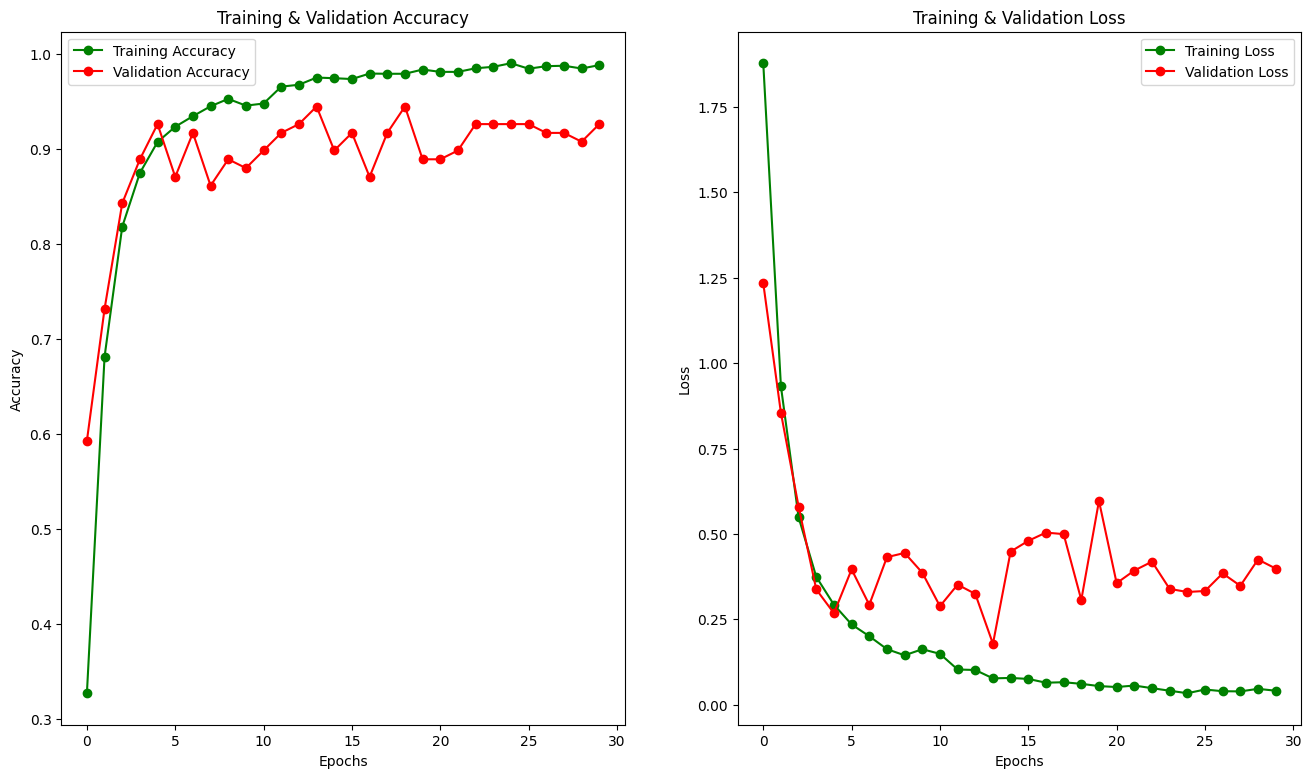

In [ ]:
def plot_loss_accuracy(history, n_epochs):
  epochs = [i for i in range(n_epochs)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig.set_size_inches(16,9)
  ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")
  ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Training & Validation Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")
  plt.show()

plot_loss_accuracy(model3_3_hist, epochs_num)

In [ ]:
loaded_model = tf.keras.models.load_model(model_path)
loaded_model.evaluate(test_data_sudoku_vgg)

2/2 [==============================] - 15s 1s/step - loss: 0.3761 - accuracy: 0.9239


[0.37606877088546753, 0.9238754510879517]

In [ ]:
prediction3_3 = loaded_model.predict(test_data_sudoku_vgg)

predictions=np.argmax(prediction3_3,axis=1)

print(predictions)

2/2 [==============================] - 15s 1s/step
[0 0 3 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 2 2 2 2 9 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 5 3 3 3 3 3 8 3 3 3 3 3 3 3 3 5 3 3 3 3
 3 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 8 5 5 5 5 5 5 5 5 3 5 6 6 6 0 6 6 6 6 6 8 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 5 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0
 8 8 9 0 9 9 6 0 9 6 9 9 9 9 0 9 9 9 9 9 9 9 9 9 8 9 9 9 9 9]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_data_sudoku_vgg.labels, predictions))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        28
           1       0.96      0.93      0.95        29
           2       0.96      0.96      0.96        27
           3       0.89      0.89      0.89        28
           4       1.00      0.97      0.98        29
           5       0.90      0.93      0.92        30
           6       0.88      0.93      0.90        30
           7       1.00      0.97      0.98        30
           8       0.88      0.93      0.90        30
           9       0.96      0.79      0.86        28

    accuracy                           0.92       289
   macro avg       0.92      0.92      0.92       289
weighted avg       0.92      0.92      0.92       289



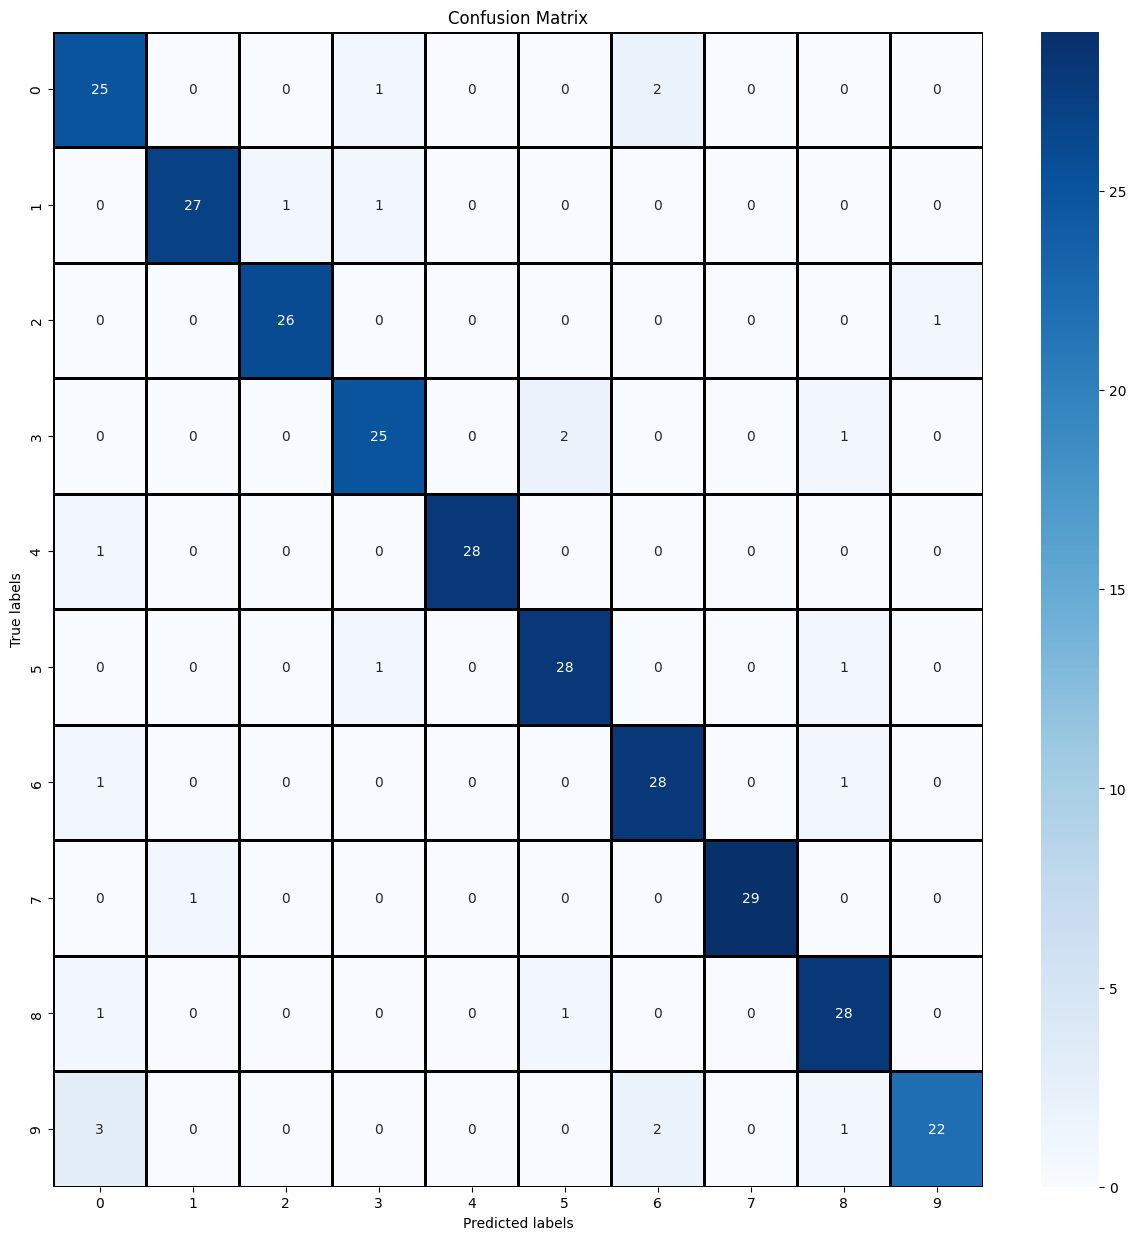

In [ ]:
from sklearn.metrics import confusion_matrix
def confusion_mat(y, predictions):
  cm = confusion_matrix(y, predictions)

  cm = pd.DataFrame(cm, index = [i for i in range(10)] , columns = [i for i in range(10)])

  plt.figure(figsize = (15,15))

  ax= plt.subplot()

  sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='g', ax=ax)

  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels');

  ax.set_title('Confusion Matrix');

  ax.xaxis.set_ticklabels(categories)
  ax.yaxis.set_ticklabels(categories)

confusion_mat(test_data_sudoku_vgg.labels, predictions)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt

def prikaz_augmentacije(image_path):
  image = load_img(image_path, target_size=(64, 64))
  image_array = img_to_array(image)
  image_array = image_array.reshape((1,) + image_array.shape)
  datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=12,
      zoom_range = 0.2,
      brightness_range=(0.5,1.5),
      fill_mode="nearest")
  augmented_images = []
  iterations = 8
  for batch in datagen.flow(image_array, batch_size=1):
      augmented_images.append(batch[0])
      iterations -= 1
      if iterations == 0:
        break

  plt.figure(figsize=(10, 10))
  plt.subplot(3, 3, 1)
  plt.imshow(image)

  plt.title("Originalna slika")

  for i, augmented_image in enumerate(augmented_images):
      plt.subplot(3, 3, i + 2)
      plt.imshow(augmented_image)
      plt.title("Transformisana slika {}".format(i + 1))
  plt.tight_layout()

  plt.show()

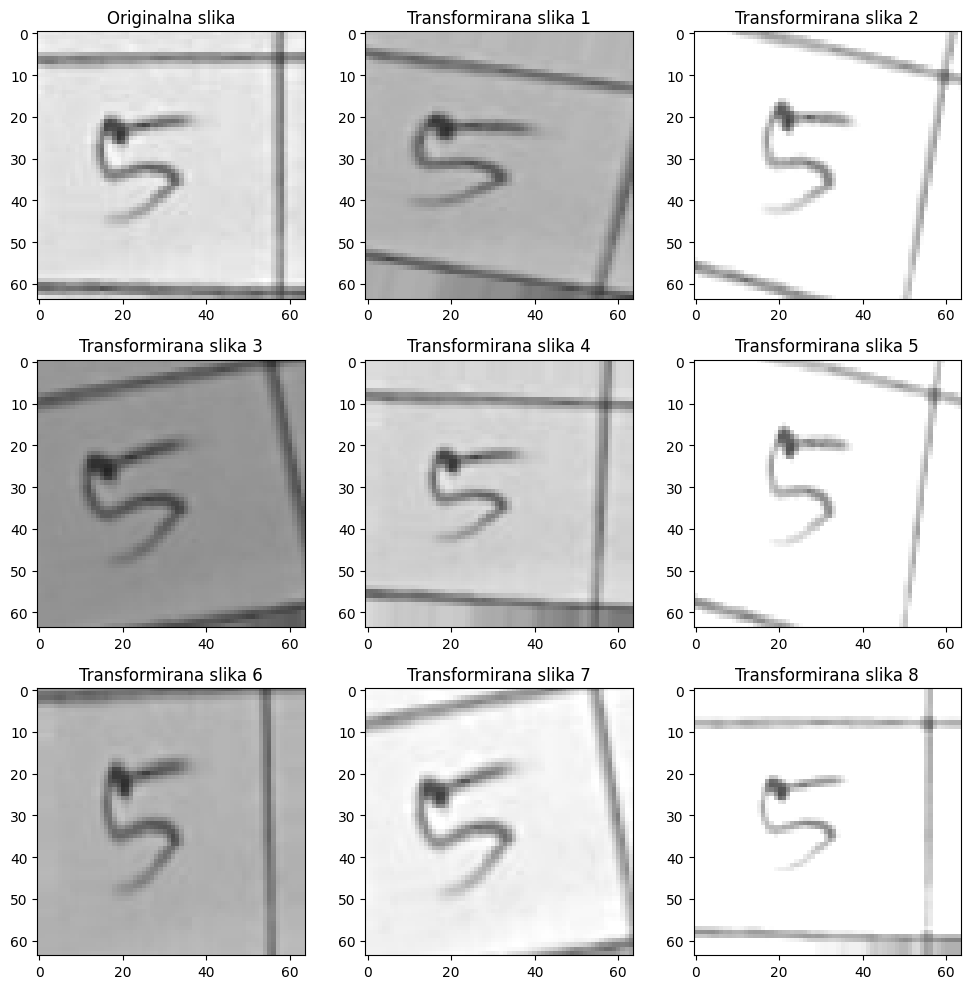

In [ ]:
prikaz_augmentacije('/content/drive/MyDrive/UNP seminarski/Sudoku cifre/train_data/5/20_35_02.738655.jpg')

# Testing the model with the camera

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def image_prediction(image_path='photo.jpg'):

  image = load_img(image_path, target_size=(64, 64))
  image_array = img_to_array(image)

  image_array = image_array / 255.0
  input_data = np.expand_dims(image_array, axis=0)

  predictions = loaded_model.predict(input_data)

  predicted_class = np.argmax(predictions)

  print("Model prediction:", predicted_class)

### 1.   Test it with a camera

<IPython.core.display.Javascript object>

Saved to photo.jpg


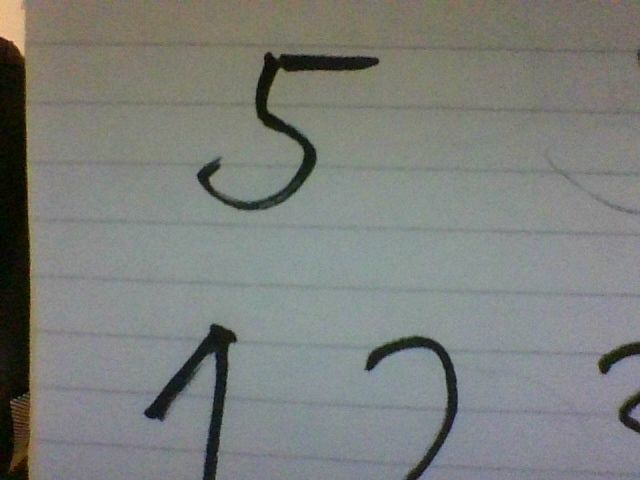


1/1 [==============================] - 0s 71ms/step
Predviđena klasa: 5


In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
  print()
  image_prediction(filename)
except Exception as err:
  print(str(err))

### 2.    Test it with an online images

In [ ]:
import requests
image_urls = ['https://i.stack.imgur.com/N98PK.jpg',
              'https://www.shutterstock.com/shutterstock/videos/23708587/thumb/1.jpg?ip=x480',
              'https://d3i71xaburhd42.cloudfront.net/7b14ccbaf08683e3e284d9bfded0712dab8f86ba/3-Figure3-1.png',
              'https://www.shutterstock.com/image-vector/vector-ink-hand-drawn-number-260nw-766185625.jpg',
              'https://ak.picdn.net/shutterstock/videos/23708545/thumb/1.jpg?ip=x480',
              'https://i.stack.imgur.com/CF1ze.jpg',
              'https://www.shutterstock.com/image-vector/number-7-painted-by-brush-260nw-741826297.jpg',
              'https://thumb.ac-illust.com/c3/c3f1db3e849f676df427981547fb8dcc_t.jpeg',
              'https://i.stack.imgur.com/j87yh.jpg']
i=0
for image_url in image_urls:
  i+=1
  img_data = requests.get(image_url).content
  with open(f'image{i}.jpg', 'wb') as handler:
      handler.write(img_data)

In [ ]:
image_prediction('/content/image8.jpg')

1/1 [==============================] - 0s 215ms/step
Model prediction: 8
